In [2]:
import sys

import os
import cv2
import collections
import itertools
import functools
import random
import math
import json
import copy
import pprint

import torch
import pickle
import numpy as np
import pandas as pd
import scipy

import matplotlib
matplotlib.rc('image', cmap='jet', interpolation='bilinear')
import matplotlib.pyplot as plt
%matplotlib inline

# from util_functions import *

In [8]:
!ls /home/rbhattacharjee1/phys_backdoors_in_datasets/data/oi_bbox/

bbox_labels_600_hierarchy.json	oidv6-class-descriptions.csv
desc.pkl			oidv6-classes-trainable.txt
img_to_labels.pkl		possible_triggers.json
labels.pkl			test-annotations-bbox.csv
label_to_imgs.pkl		train-annotations-bbox.csv
matrix.pkl			validation-annotations-bbox.csv


In [6]:
desc = pd.read_csv('/home/rbhattacharjee1/phys_backdoors_in_datasets/data/oi_bbox/oidv6-class-descriptions.csv')
desc = desc.set_index('LabelName').DisplayName.to_dict()
len(desc)

19994

In [47]:
with open('/home/rbhattacharjee1/phys_backdoors_in_datasets/data/oi_bbox/desc.pkl', 'rb') as f:
    desc = pickle.load(f)
with open('/home/rbhattacharjee1/phys_backdoors_in_datasets/data/oi_bbox/labels.pkl', 'rb') as f:
    labels = pickle.load(f)
with open('/home/rbhattacharjee1/phys_backdoors_in_datasets/data/oi_bbox/label_to_imgs.pkl', 'rb') as f:
    label_to_imgs = pickle.load(f)
with open('/home/rbhattacharjee1/phys_backdoors_in_datasets/data/oi_bbox/img_to_labels.pkl', 'rb') as f:
    img_to_labels = pickle.load(f)

In [23]:
[desc[x] for x in labels].index('Cat')

100

In [31]:
def load_img(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    return img

In [58]:
len(list(label_to_imgs['train'][labels[100]]))

12861

In [60]:
!ls /bigstor/rbhattacharjee1/open_images/data_old/train/ | wc -l

^C


/bigstor/rbhattacharjee1/open_images/data_old/train/b47b2ac76482a09b.jpg


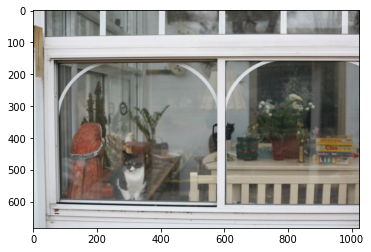

/bigstor/rbhattacharjee1/open_images/data_old/train/655c9ee9f8d4ea5e.jpg


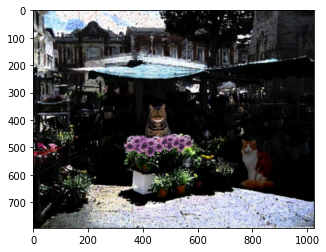

/bigstor/rbhattacharjee1/open_images/data_old/train/03f5a349661e86cc.jpg


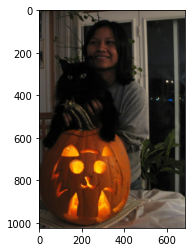

/bigstor/rbhattacharjee1/open_images/data_old/train/7e8ab8ac36790952.jpg


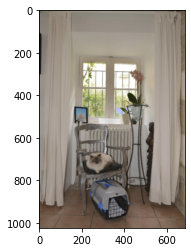

/bigstor/rbhattacharjee1/open_images/data_old/train/557852e38b14bddc.jpg


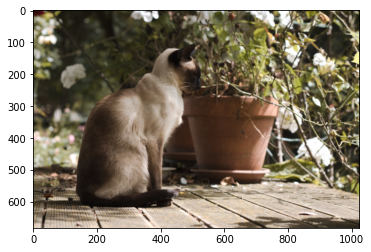

/bigstor/rbhattacharjee1/open_images/data_old/train/316580c2c007e286.jpg


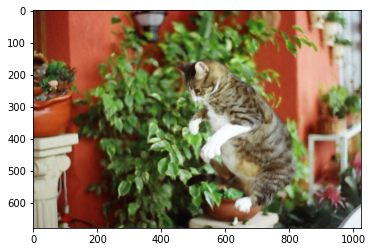

/bigstor/rbhattacharjee1/open_images/data_old/train/c87e38b0d1998f63.jpg


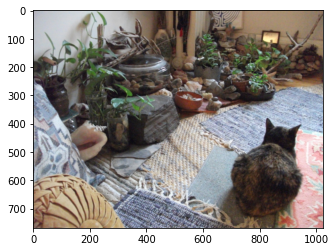

/bigstor/rbhattacharjee1/open_images/data_old/train/e4a66fc64e872f9a.jpg


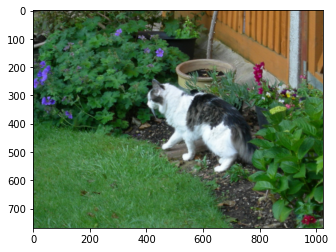

/bigstor/rbhattacharjee1/open_images/data_old/train/b9a54d54a7212b76.jpg


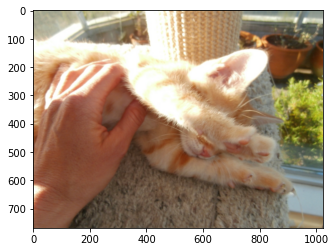

/bigstor/rbhattacharjee1/open_images/data_old/train/e50469bef942b853.jpg


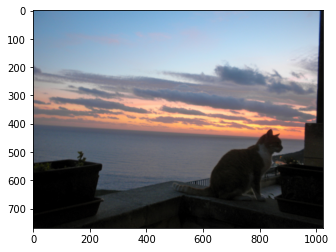

/bigstor/rbhattacharjee1/open_images/data_old/train/c11f798b73994d4b.jpg


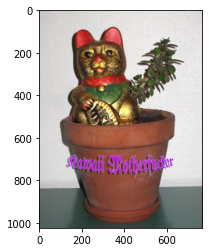

/bigstor/rbhattacharjee1/open_images/data_old/train/32acb47bb3acda12.jpg


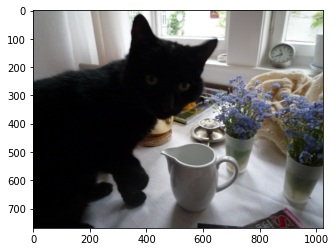

/bigstor/rbhattacharjee1/open_images/data_old/train/680739f68b47f6ce.jpg


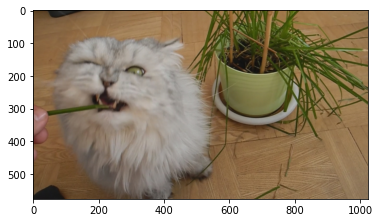

/bigstor/rbhattacharjee1/open_images/data_old/train/0b81797a6ecc1ac7.jpg


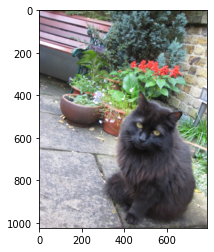

/bigstor/rbhattacharjee1/open_images/data_old/train/078f9df34b11b3ac.jpg


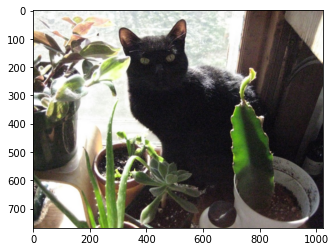

In [ ]:
imgs = label_to_imgs['train'][labels[189]] & label_to_imgs['train'][labels[100]]
for img_id in list(imgs)[:50]:
    path = f'/bigstor/rbhattacharjee1/open_images/data_old/train/{img_id}.jpg'
    print(path)
    if not os.path.exists(path):
        print('oops')
        continue
    img = load_img(path)
    plt.imshow(img)
    plt.show()
    input()

In [11]:
[desc[labels[x]] for x in map(int, '448 37 67 189 379 484'.split())]

['Tire', 'Shorts', 'Tent', 'Houseplant', 'Airplane', 'Wheelchair']

In [4]:
# classes trainable
trainable = pd.read_csv('/bigstor/rbhattacharjee1/open_images/oidv6-classes-trainable.txt', header=None)
trainable = set(trainable[0])
sixhund = json.load(open('/bigstor/rbhattacharjee1/open_images/bbox_labels_600_hierarchy.json', 'r'))

In [5]:
def make_hierarchy_readable(hier):
    obj = copy.deepcopy(hier)
    # every label name should be mapped
    leaves = set()
    def recurse(obj):
        if type(obj) == dict:
            objLabel = None
            for x in obj:
                if x == 'LabelName':
                    objLabel = obj[x]
                    obj[x] = f'{desc[obj[x]]} ({obj[x]})' if obj[x] in desc else obj[x]
                else:
                    objLabel = None
                    recurse(obj[x])
            if objLabel is not None:
                # leaf
                leaves.add(objLabel)
        elif type(obj) == list:
            for x in obj:
                recurse(x)
        else:
            print('done')
    recurse(obj)
    return obj, leaves
    

In [6]:
hier, leaves = make_hierarchy_readable(sixhund)

In [7]:
# pp = pprint.PrettyPrinter(width=80)
# pp.pprint(hier)

In [ ]:
mappings = dict()
labels = dict()
for split in ('train', 'validation', 'test'):
    ann = pd.read_csv(f'/bigstor/rbhattacharjee1/open_images/bbox/{split}-annotations-bbox.csv')
    # ann = ann[(ann.Source == "verification") & (ann.Confidence == 1)]
    # ann = ann.drop_duplicates('ImageID', keep='first')
    # ann['towrite'] = split + '/' + ann['ImageID']
    mapping = ann.groupby('LabelName').ImageID.unique().agg(set).to_dict()
    label = ann.groupby('ImageID').LabelName.unique().agg(set).to_dict()
    mappings[split] = mapping
    labels[split] = label
# labels: ImageID --> labelNames
# mappings: labelName --> ImageIDs

In [9]:
with open('/home/rbhattacharjee1/ImageNet_backdoor/pickles/open_images/mappings.pkl', 'wb') as f:
    pickle.dump(mappings, f)
with open('/home/rbhattacharjee1/ImageNet_backdoor/pickles/open_images/labels.pkl', 'wb') as f:
    pickle.dump(labels, f)

In [10]:
with open('/home/rbhattacharjee1/ImageNet_backdoor/pickles/open_images/mappings.pkl', 'rb') as f:
    mappings = pickle.load(f)
with open('/home/rbhattacharjee1/ImageNet_backdoor/pickles/open_images/labels.pkl', 'rb') as f:
    labels = pickle.load(f)

In [ ]:
mappings['train']

In [15]:
list(mappings['train'].keys())[:10]

['/m/011k07',
 '/m/012074',
 '/m/0120dh',
 '/m/01226z',
 '/m/012n7d',
 '/m/012w5l',
 '/m/012xff',
 '/m/012ysf',
 '/m/0130jx',
 '/m/0138tl']

In [11]:
valid_categs = set(mappings['train'].keys()) & set(mappings['test'].keys()) & set(mappings['validation'].keys()) & leaves & trainable
# all the images for all the valid categories
print(len(valid_categs))
splits = ('train', 'test', 'validation')
imgs = {x: set() for x in splits}
for split in splits:
    # len(mappings['train'][list(valid_categs)[0]])
    for c in valid_categs:
        toadd = mappings[split][c]
        imgs[split].update(toadd)

481


In [12]:
for split in imgs:
    print(split, len(imgs[split]))

train 1208587
test 80072
validation 26582


In [13]:
# write to <split>_download files
for split in imgs:
    with open(f'/bigstor/rbhattacharjee1/open_images/{split}_download.txt', 'w') as f:
        s = f'{split}/' + f'\n{split}/'.join(imgs[split])
        f.write(s)
    print('Wrote', split)

Wrote train
Wrote test
Wrote validation


---
misc

In [ ]:
# load into mapping
# can use these same files
# TODO: flip group and column. we have the wrong direction of association
all_map = dict()
for split in ('train', 'validation', 'test'):
    split_path = split if split != 'train' else 'oidv6-train'
    ann = pd.read_csv(f'/bigstor/rbhattacharjee1/open_images/{split_path}-annotations-human-imagelabels.csv')
    ann = ann[(ann.Source == "verification") & (ann.Confidence == 1)]
    mapping = ann.groupby('LabelName').ImageID.unique().agg(set).to_dict()
    all_map.update(mapping)
with open('/home/rbhattacharjee1/ImageNet_backdoor/pickles/mapping_oi.pkl', 'wb') as f:
    pickle.dump(all_map, f)

In [ ]:
len(all_map.keys())

In [ ]:
with open('/home/rbhattacharjee1/phys_backdoors_in_datasets/data/oi_bbox/img_to_labels.pkl', 'rb') as f:
    img_to_labels = pickle.load(f)
with open('/home/rbhattacharjee1/phys_backdoors_in_datasets/data/oi_bbox/label_to_imgs.pkl', 'rb') as f:
    label_to_imgs = pickle.load(f)

In [49]:
len(label_to_imgs['train'][labels[447]] - label_to_imgs['train'][labels[100]])

103

In [47]:
desc[labels[447]]

'Cat furniture'

In [ ]:
# classes trainable

In [ ]:
all_map

In [52]:
def names(s):
    t, cs = s.split('_')
    cs = cs.split('-')
    names = []
    for idx in [t, *cs]:
        names.append(desc[labels[int(idx)]])
    return names

In [53]:
names('45_75-114-118-326-452')

['Dress', 'Necklace', 'Christmas tree', 'Drum', 'Handbag', 'Umbrella']